In [2]:
import matplotlib.pyplot as plt
import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import urllib
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

IDEIA: usar regressao logistica para resolver o problema, classificando as palavras que mais estao relacionadas com reviews negativas, e depois podemos usar um tfidf para achar as reviews mais negativas??

DATASET a ser ultilizado: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce 

In [2]:
#TODO - tratar bonitinho para a regressao -> separar o csv de reviews, e pegar apenas as reviews que tem notas negativas (<= 3) E que tem comentario. 
#TODO - fazer train test split, aplicar a regressao

In [3]:
url = "https://gist.githubusercontent.com/alopes/5358189/raw/2107d809cca6b83ce3d8e04dbd9463283025284f/stopwords.txt"
stopwords_list = urllib.request.urlopen(url).read().decode()
stopwords = set(stopwords_list.split())
stopwords.remove("não") #removendo o nao pois eh uma palavra bem importante para reviews negativas

In [4]:
dataset = "datasets/olist_order_reviews_dataset.csv"
df = pd.read_csv(dataset)
print(df.shape)
df.head()

(99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [8]:
# drop rows with NaN values in review_comment_title and review_comment_message columns
df.dropna(subset=['review_comment_title', 'review_comment_message'], inplace=True)

# filter the dataset to include only reviews with a score that is equal or lower than 3
filtered_df = df[df['review_score'] <= 2]

# select only the desired columns
filtered_df = filtered_df.loc[:, ['review_score', 'review_comment_title', 'review_comment_message']]

# print the filtered dataset
print(filtered_df.shape)
filtered_df.head()

(2247, 3)


,review_score,review_comment_title,review_comment_message
19,1,Não chegou meu produto,Péssimo
167,1,Médio,A peça não serviu
190,1,falta de produto e quebra,Faltou 1 produto e os que recebi 1 veio quebrado
197,1,não recebi ainda,aqui está descrevendo como entregue só que ate...
276,1,Horrível,Cancelaram a minha compra um dia antes da entr...


In [104]:
# split the dataset into training and test sets
df_train, df_test = train_test_split(filtered_df, test_size=0.2, random_state=42)

# print the shapes of the training and test sets
print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)
df_train.head()

Training set shape: (1797, 3)
Test set shape: (450, 3)


,review_score,review_comment_title,review_comment_message
19746,1,Relógio errado,"Comprei um produto,me mandaram um outro produt..."
95122,1,Veio faltando,"Chegou somente o preto, está faltando o colorido"
92001,1,Péssimo,Comprei um produto de uma marca e recebi outro...
97164,1,0,"Irresponsável,não tem nenhuma preocupação com ..."
30093,1,Modelo diferente.,comprei o cobertor e veio outro modelo.


In [105]:
X_train = df_train['review_comment_message']
y_train = df_train['review_score']

X_test = df_test['review_comment_message']
y_test = df_test['review_score']

classificador = Pipeline([
                        ('meu_vetorizador', TfidfVectorizer(stop_words = list(stopwords))),
                        ('meu_classificador', LogisticRegression(penalty=None, solver='saga', max_iter=10000))
                        ])
classificador.fit(X_train,y_train)
y_pred = classificador.predict(X_test)
acc = accuracy_score(y_pred,y_test)
print(acc)

0.7133333333333334


Palavras relacionadas a reviws de score 1:

(1, 3795)


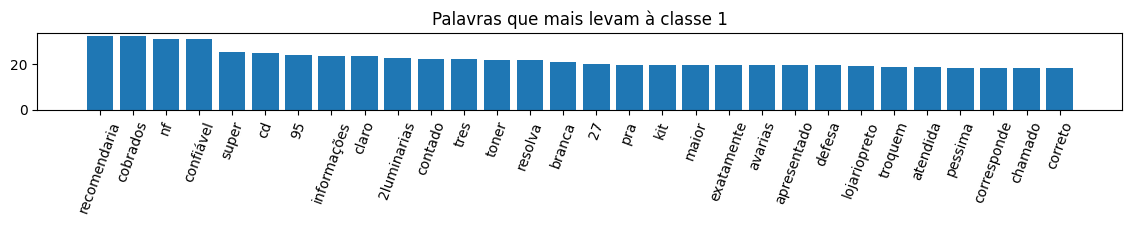

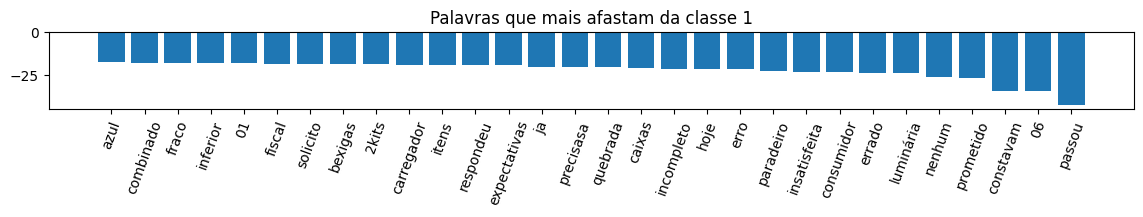

In [106]:
vocabulario = classificador['meu_vetorizador'].vocabulary_
pesos = classificador['meu_classificador'].coef_
print(pesos.shape)

classe_alvo = 0
classe_alvo_str = classificador.classes_[classe_alvo]

palavras_e_pesos = []
for palavra in vocabulario.keys():
    j = vocabulario[palavra]
    coeficiente = pesos[classe_alvo,j]
    palavras_e_pesos.append( (coeficiente, palavra) )

tuplas_ordenadas = sorted(palavras_e_pesos, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais levam à classe ' + str(classe_alvo_str))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.show()

eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais afastam da classe ' + str(classe_alvo_str))
plt.bar(eixo_x[-n_palavras:], contagens[-n_palavras:])
plt.xticks(eixo_x[-n_palavras:], palavras[-n_palavras:], rotation=70)
plt.show()

Palavras relacionadas a reviws de score 2:

Palavras relacionadas a reviws de score 3:

POR STEMMING:

100%|██████████| 2247/2247 [00:00<00:00, 31767.53it/s]


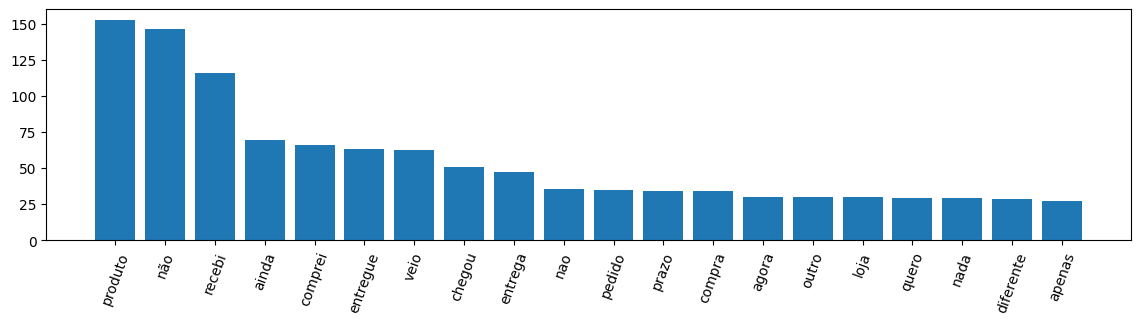

In [9]:
#stemmer = SnowballStemmer("portuguese")
# reviews = [s for s in filtered_df['review_comment_message']]
# for n in tqdm(range (len(reviews))):
#     reviews[n] = " ".join([stemmer.stem(p) for p in reviews[n].lower().split()])

lemmatizer = WordNetLemmatizer()
reviews = [s for s in filtered_df['review_comment_message']]
for n in tqdm(range (len(reviews))):
    reviews[n] = " ".join([lemmatizer.lemmatize(p) for p in reviews[n].split()])

vectorizer = TfidfVectorizer(max_features=5000, stop_words = list(stopwords), binary=True)
# x = vectorizer.fit_transform(reviews)
x = vectorizer.fit_transform(filtered_df['review_comment_message'])
x = np.sum(x, axis=0)

tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 20
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.show()

Olhando as palavras para reviews boas para descobrir se ha similaridades

In [10]:
# drop rows with NaN values in review_comment_title and review_comment_message columns
df.dropna(subset=['review_comment_title', 'review_comment_message'], inplace=True)

# filter the dataset to include only reviews with a score that is equal or lower than 3
filtered_df = df[df['review_score'] >= 4]

# select only the desired columns
filtered_df = filtered_df.loc[:, ['review_score', 'review_comment_title', 'review_comment_message']]

# print the filtered dataset
print(filtered_df.shape)
filtered_df.head()

(6855, 3)


,review_score,review_comment_title,review_comment_message
9,4,recomendo,aparelho eficiente. no site a marca do aparelh...
15,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes..."
22,5,Ótimo,Loja nota 10
34,4,Muito bom.,Recebi exatamente o que esperava. As demais en...
36,5,Bom,"Recomendo ,"


100%|██████████| 6855/6855 [00:00<00:00, 56142.34it/s]


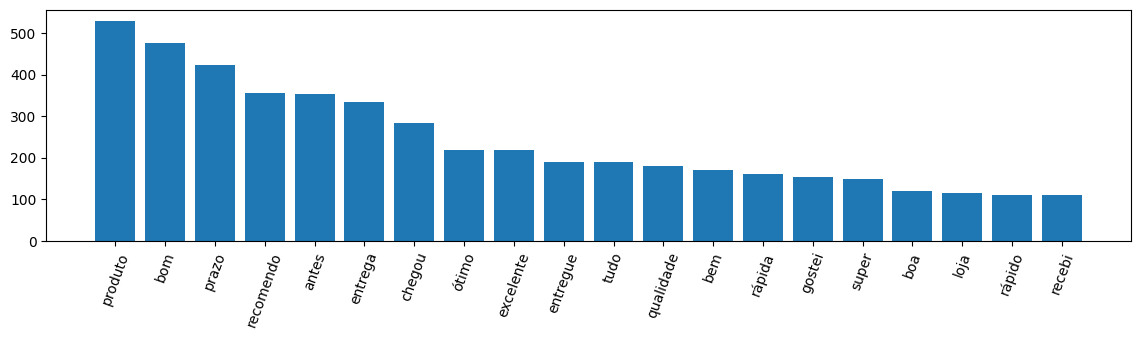

In [11]:
lemmatizer = WordNetLemmatizer()
reviews = [s for s in filtered_df['review_comment_message']]
for n in tqdm(range (len(reviews))):
    reviews[n] = " ".join([lemmatizer.lemmatize(p) for p in reviews[n].split()])

vectorizer = TfidfVectorizer(max_features=5000, stop_words = list(stopwords), binary=True)
# x = vectorizer.fit_transform(reviews)
x = vectorizer.fit_transform(filtered_df['review_comment_message'])
x = np.sum(x, axis=0)

tuplas = [ (x[0,vectorizer.vocabulary_[i]], i) for i in vectorizer.vocabulary_.keys() ]
tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 20
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,3))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.show()